## Inception with uncertainty

In [1]:
import pandas as pd
train_class = pd.read_csv('data/train_split_v4.csv', sep=' ')#, header=True)#, names=['patientID', 'image_path', 'class'])
test_class = pd.read_csv('data/test_split_v4.csv', sep=' ')#, header=True)#, names=['patientID', 'image_path', 'class'])

In [2]:
def load_pictures (data_frame,data_dir,channels):
    import numpy as np
    from PIL import Image
    pics = []
    for img in data_frame['image_path'].values:
        if channels ==3:
            pics.append(np.array(Image.open(data_dir + img))[:, :,:3])
        else:
            pics.append(np.array(Image.open(data_dir + img))[:, :,0])

    return np.array(pics)

In [3]:
num_channels = 3
X_train = load_pictures(train_class,"data/train/",channels = num_channels)
X_test = load_pictures(test_class,"data/test/",channels = num_channels)
print("Number of images:", X_train.shape, X_test.shape)

Number of images: (13601, 200, 200, 3) (1541, 200, 200, 3)


In [4]:
from codvidutils.imageproc import map_categorical
import numpy as np
values_dict = {'COVID-19': 1,'pneumonia': 2,'normal': 0}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
train_class['class_categorical'] = train_class['class'].apply(map_categorical, args=(values_dict,))
diseaseID_train = np.asarray(train_class["class_categorical"])
diseaseID_test = np.asarray(test_class["class_categorical"])
print('shape X: {} {},  disease_ID (Y): {} {}'.format(X_train.shape[0], X_test.shape[0], diseaseID_train.shape[0], diseaseID_test.shape[0] ))

shape X: 13601 1541,  disease_ID (Y): 13601 1541


In [ ]:
def under_sampling(X, Y,dicto):
    from collections import Counter
    

In [5]:
from collections import Counter
counter = Counter (diseaseID_train)
print(counter)
dicto = {2: 3000, 0: 3000, 1:counter[1]}
print(dicto)

Counter({0: 7966, 2: 5448, 1: 187})
{0: 3000, 1: 187, 2: 3000}


In [6]:
from imblearn.under_sampling import RandomUnderSampler
#X = X.reshape(X,X.shape[0],-1)
X_train = X_train.reshape(X_train.shape[0],-1)
print(X_train.shape)
under = RandomUnderSampler(sampling_strategy =dicto)
X_train, diseaseID_train = under.fit_resample(X_train, diseaseID_train)
# summarize class distribution
if num_channels == 3:
    X_train = X_train.reshape(X_train.shape[0],200,200,3)
else:
    X_train = X_train.reshape(X_train.shape[0],200,200)
    
print(diseaseID_train.shape)
print(X_train.shape)

(13601, 120000)
(6187,)
(6187, 200, 200, 3)


In [7]:
print("Normal train: ",diseaseID_train[diseaseID_train==0].shape)
print("Pneumonia train: ",diseaseID_train[diseaseID_train==2].shape)
print("COVID train: ",diseaseID_train[diseaseID_train==1].shape)
print("*******************************************************")
print("Normal test: ",diseaseID_test[diseaseID_test==0].shape)
print("Pneumonia test: ",diseaseID_test[diseaseID_test==2].shape)
print("COVID test: ",diseaseID_test[diseaseID_test==1].shape)

Normal train:  (3000,)
Pneumonia train:  (3000,)
COVID train:  (187,)
*******************************************************
Normal test:  (885,)
Pneumonia test:  (592,)
COVID test:  (64,)


In [ ]:
def adding_images(X, Y,strides= 5,kernel =None ):
    from codvidutils import nwpic as nw
    new_X = nw.new_pictures_arrays(X[Y==1],strides)
    X = X[:,10:190,10:190]
    new_Y = np.ones(new_X.shape[0])
    X = np.concatenate([X,new_X],axis=0)
    Y = np.concatenate([Y,new_Y],axis=0)
    return X, Y

In [ ]:

#X_train,diseaseID_train  = adding_images(X_train, diseaseID_train,strides = 10)
print(X_test.shape)

In [8]:
from codvidutils import nwpic as nw
"""
News images to train 
"""
X_train_news = nw.new_pictures_arrays(X_train[diseaseID_train==1],strides=10)
diseaseID_train_news = np.ones(X_train_news.shape[0])

X_train = X_train[:,10:190,10:190]
X_train = np.concatenate([X_train,X_train_news],axis=0)
diseaseID_train = np.concatenate([diseaseID_train,diseaseID_train_news],axis=0)
del X_train_news, diseaseID_train_news

In [9]:
"""
News images to test 
"""
from codvidutils import nwpic as nw
X_test_news = nw.new_pictures_arrays(X_test[diseaseID_test==1])
new_covid= X_test_news.shape[0]
diseaseID_test_news = np.ones(new_covid)
X_test = X_test[:,10:190,10:190]
X_test = np.concatenate([X_test,X_test_news],axis=0)
diseaseID_test = np.concatenate([diseaseID_test,diseaseID_test_news],axis=0)
del X_test_news, diseaseID_test_news

In [10]:
X_test = X_test/255
X_train = X_train/255

In [11]:
Y_train = np.copy(diseaseID_train)
del diseaseID_train
Y_train[Y_train==2]=0
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0

In [ ]:
def inception_block(previous_layer, p_drop,filters =[64,128,32,32]):
    from keras.layers import concatenate, Conv2D, Dropout, MaxPooling2D
    from keras.regularizers import l2
    rama_1 = Conv2D(filters=filters[0], kernel_size=(1,1), activation='relu')(previous_layer)
    rama_1 = Dropout(rate = p_drop)(rama_1)
    
    rama_2 = Conv2D(filters=filters[1], kernel_size=(1,1), activation='relu')(previous_layer)
    rama_2 = Dropout(rate = p_drop)(rama_2)
    rama_2 = Conv2D(filters=filters[1], kernel_size=(3,3), activation='relu',padding="same")(rama_2)
    rama_2 = Dropout(rate = p_drop)(rama_2)
    
    rama_3 = Conv2D(filters=filters[2], kernel_size=(1,1), activation='relu')(previous_layer)
    rama_3 = Dropout(rate = p_drop)(rama_3)
    rama_3 = Conv2D(filters=filters[2], kernel_size=(5,5), activation='relu',padding="same")(rama_3)
    rama_3 = Dropout(rate = p_drop)(rama_3)
    
    rama_4 = MaxPooling2D(pool_size=(3,3),padding="same",strides=1)(previous_layer)
    rama_4 = Dropout(rate = p_drop)(rama_4)
    rama_4 = Conv2D(filters=filters[3], kernel_size=(1,1), activation='relu',padding="same")(rama_4)
    rama_4 = Dropout(rate = p_drop)(rama_4)
    
    inception = concatenate([rama_1, rama_2,rama_3,rama_4])
    return inception

In [12]:
def inception_block_R(previous_layer, p_drop,p_l2,filters =[64,128,32,32]):
    from keras.layers import concatenate, Conv2D, Dropout, MaxPooling2D
    from keras.regularizers import l2
    
    previous_drop = Dropout(rate = p_drop)(previous_layer)
    rama_1 = Conv2D(filters=filters[0], kernel_size=(1,1), activation='relu',
                             bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(previous_drop)
    rama_1 = Dropout(rate = p_drop)(rama_1)
    
    rama_2 = Conv2D(filters=filters[1], kernel_size=(1,1), activation='relu',
                             bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(previous_drop)
    rama_2 = Dropout(rate = p_drop)(rama_2)
    rama_2 = Conv2D(filters=filters[1], kernel_size=(3,3), activation='relu',padding="same",
                             bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(rama_2)
    rama_2 = Dropout(rate = p_drop)(rama_2)
    
    rama_3 = Conv2D(filters=filters[2], kernel_size=(1,1), activation='relu',
                             bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(previous_drop)
    rama_3 = Dropout(rate = p_drop)(rama_3)
    rama_3 = Conv2D(filters=filters[2], kernel_size=(5,5), activation='relu',padding="same",
                             bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(rama_3)
    rama_3 = Dropout(rate = p_drop)(rama_3)
    
    rama_4 = MaxPooling2D(pool_size=(3,3),padding="same",strides=1)(previous_layer)
    rama_4 = Dropout(rate = p_drop)(rama_4)
    rama_4 = Conv2D(filters=filters[3], kernel_size=(1,1), activation='relu',padding="same",
                             bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(rama_4)
    rama_4 = Dropout(rate = p_drop)(rama_4)
    
    inception = concatenate([rama_1, rama_2,rama_3,rama_4])
    return inception

In [13]:
"""
Incep_6 archiquecture using Functional api
"""
def deep_inception_R(p_drop,p_l2):
    from keras.layers import MaxPooling2D, Dense, Flatten, GlobalMaxPooling2D, Dropout, Input
    #from keras.regularizers import l2
    input_layer = Input(shape= (180,180,3,))
    input_drop = Dropout(rate = p_drop)(input_layer)
    
    inception_1 = inception_block_R(input_drop,p_drop,p_l2)
    pool_1 = MaxPooling2D()(inception_1)
    
    inception_2 = inception_block_R(pool_1,p_drop,p_l2)
    pool_2 = MaxPooling2D()(inception_2)
    
    inception_3 = inception_block_R(pool_2,p_drop,p_l2)
    pool_3 = MaxPooling2D()(inception_3)
    
    inception_4 = inception_block_R(pool_3,p_drop,p_l2)
    pool_4 = MaxPooling2D()(inception_4)
    
    inception_5 = inception_block_R(pool_4,p_drop,p_l2)
    pool_5 = MaxPooling2D()(inception_5)
    
    inception_6 = inception_block_R(pool_5,p_drop,p_l2)
    
    gobal = GlobalMaxPooling2D()(pool_6)
    gobal = Dropout(rate= p_drop)(gobal)
    
    dense = Dense(units=256,activation="relu")(gobal)
    dense = Dropout(rate= p_drop)(dense)
    dense = Dense(units=64,activation="relu")(dense)
    dense = Dropout(rate= p_drop)(dense)
    out_layer= Dense(units =1, activation= "sigmoid")(dense)
    
    from keras.models import Model
    deep = Model(inputs=input_layer, outputs=out_layer)
    return deep


Using TensorFlow backend.


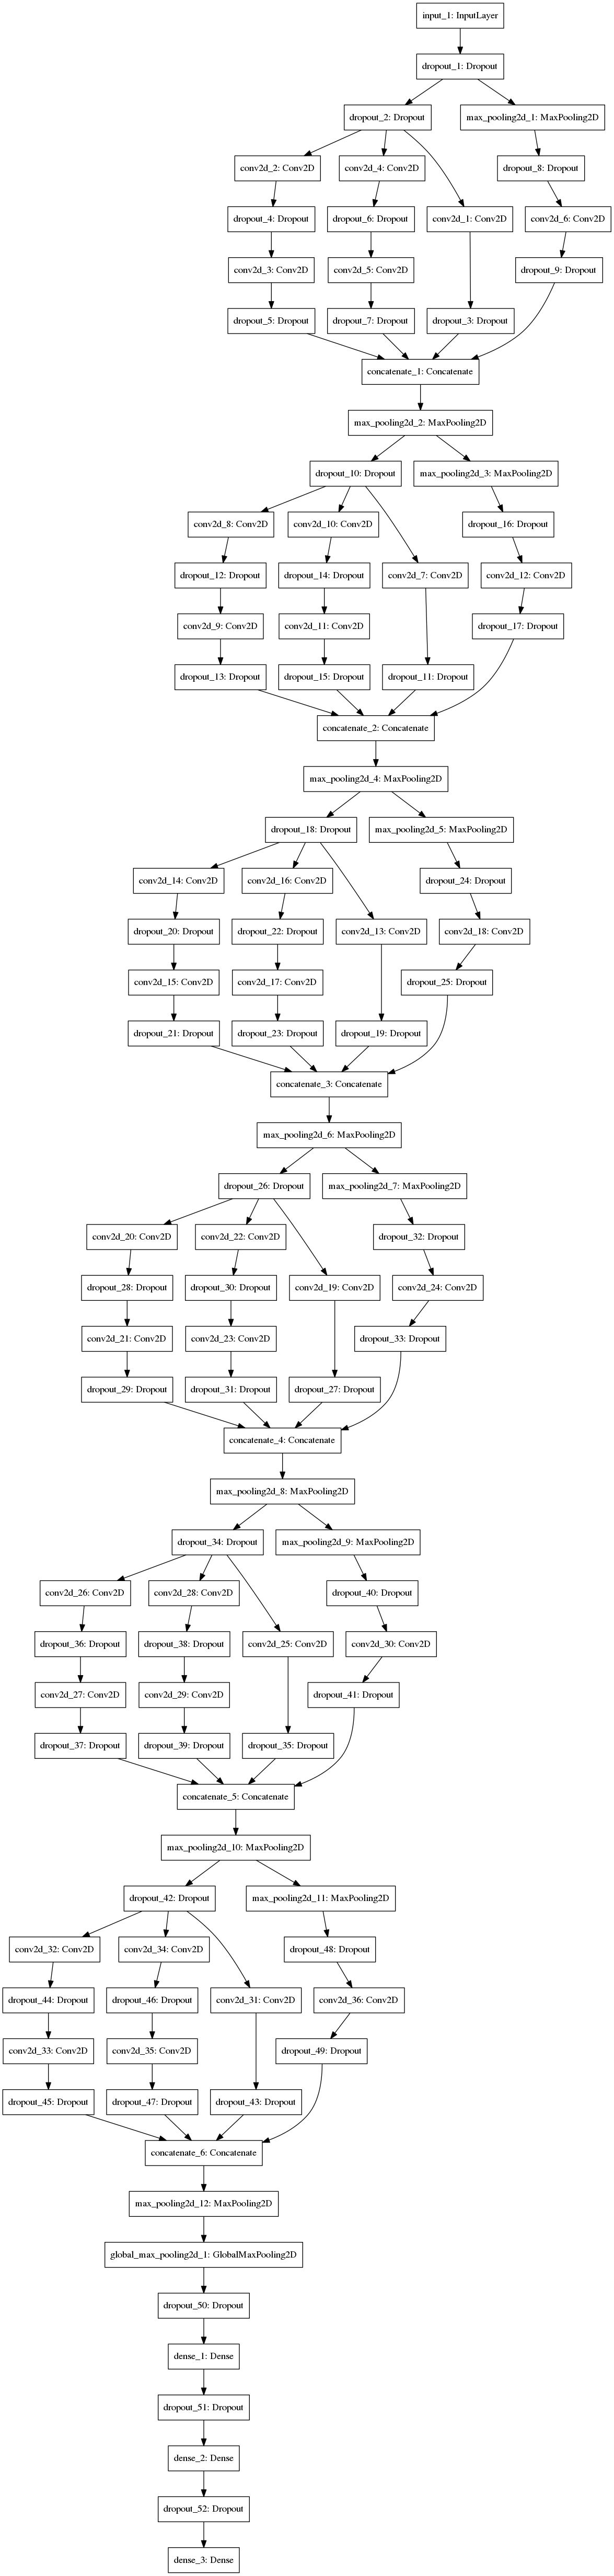

In [14]:
model = deep_inception_R(p_drop = .25,p_l2=0.00001)
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [15]:
print('Train shape X: {},  Y: {} \n Test shape X: {}, Y: {}'.format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

Train shape X: (7870, 180, 180, 3),  Y: (7870,) 
 Test shape X: (3141, 180, 180, 3), Y: (3141,)


In [16]:
del model

In [20]:
from codvidutils.utils import weigths2loss
dic_weights = weigths2loss(Y_train)
print(dic_weights)

{0: 0.23761118170266837, 1: 0.7623888182973316}


In [28]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import keras
import keras.backend as K
import tensorflow as tf
filepath="Inception_bestmodel_trained.hdf5"
prob = []     
hist_for =[]
#***********************************************************
for i in range(3):
    
    K.clear_session()# p_drop = 0.05, p_l2 = 0.000050 parece ser bueno pero lento
    model = deep_inception_R(p_drop = 0.05, p_l2 = 0.000050)
    filepath="Inception_bestmodel_"+str(i)+"_trained.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    ASG = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=ASG, loss='binary_crossentropy', metrics=['acc',"mse"])
  
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
       
        history = model.fit(X_train, Y_train, epochs=12, batch_size=32, callbacks= [checkpoint],verbose=1, class_weight=dic_weights,validation_data=(X_test, Y_test))
        #history = model.fit(X_train, Y_train, epochs=16, batch_size=32, callbacks= [checkpoint],verbose=1,validation_data=(X_test, Y_test))
        prob += [model.predict(X_test)]
        hist_for += [history]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Train on 7870 samples, validate on 3141 samples
Epoch 1/12
7870/7870 [==============================] - 120s 15ms/step - loss: 0.3804 - acc: 0.4483 - mse: 0.2543 - val_loss: 0.8065 - val_acc: 0.5135 - val_mse: 0.2491

Epoch 00001: val_acc improved from -inf to 0.51353, saving model to Inception_bestmodel_0_trained.hdf5
Epoch 2/12
7870/7870 [==============================] - 114s 14ms/step - loss: 0.3453 - acc: 0.5668 - mse: 0.2414 - val_loss: 0.7255 - val_acc: 0.6867 - val_mse: 0.2187

Epoch 00002: val_acc improved from 0.51353 to 0.68672, saving model to Inception_bestmodel_0_trained.hdf5
Epoch 3/12
7870/7870 [==============================] - 113s 14ms/step - loss: 0.2820 - acc: 0.7457 - mse: 0.1749 - val_loss: 0.6280 - val_acc: 0.7256 - val_mse: 0.1810

Epoch 00003: val_acc improved from 0.68672 to 0.72557, saving model to Inception_bes


Epoch 00007: val_acc improved from 0.77905 to 0.79656, saving model to Inception_bestmodel_2_trained.hdf5
Epoch 8/12
7870/7870 [==============================] - 114s 14ms/step - loss: 0.1861 - acc: 0.8714 - mse: 0.0946 - val_loss: 0.6000 - val_acc: 0.7275 - val_mse: 0.1764

Epoch 00008: val_acc did not improve from 0.79656
Epoch 9/12
7870/7870 [==============================] - 114s 15ms/step - loss: 0.1768 - acc: 0.8756 - mse: 0.0878 - val_loss: 0.5459 - val_acc: 0.7714 - val_mse: 0.1564

Epoch 00009: val_acc did not improve from 0.79656
Epoch 10/12
7870/7870 [==============================] - 114s 15ms/step - loss: 0.1697 - acc: 0.8855 - mse: 0.0828 - val_loss: 0.5526 - val_acc: 0.7603 - val_mse: 0.1596

Epoch 00010: val_acc did not improve from 0.79656
Epoch 11/12
7870/7870 [==============================] - 114s 14ms/step - loss: 0.1626 - acc: 0.8925 - mse: 0.0783 - val_loss: 0.6765 - val_acc: 0.6839 - val_mse: 0.2068

Epoch 00011: val_acc did not improve from 0.79656
Epoch 12/12

In [ ]:
print("Normal train: ",Y_train[Y_train==0].shape)
print("COVID train: ",Y_train[Y_train==1].shape)
print("*******************************************************")
print("Normal test: ",Y_test[Y_test==0].shape)
print("COVID test: ",Y_test[Y_test==1].shape)

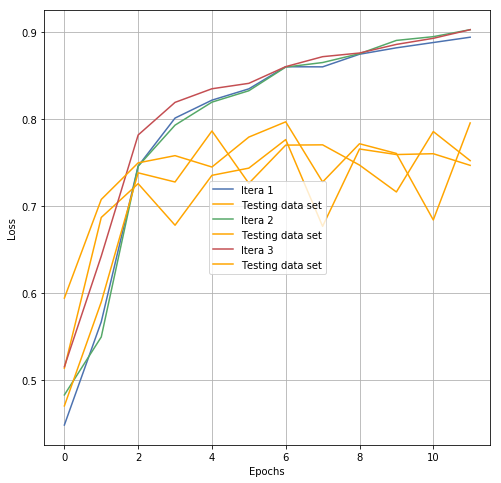

In [33]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
plt.grid(True)
name="acc"
i=1
for h in hist_for:
    plt.plot(h.history[name] ,label="Itera "+str(i))
    i=i+1
    plt.plot(h.history["val_"+name], color= "orange" ,label="Testing data set")
    
plt.ylabel("Loss")
plt.xlabel('Epochs')
plt.legend(loc='center')
plt.show()

## Uncertainty

In [43]:
p_drop = 0.05
p_l2 = 0.000050
tau = (1 - p_drop) / (2 * 3 * p_l2)
Dsis = 1 / tau
print(tau)
print(Dsis)

3166.666666666666
0.0003157894736842106


In [46]:
"""
Means & desvs
"""
prob = np.asarray(prob)
Mean = np.mean(prob,axis =0)
Dsta = np.std(prob,axis = 0)
unc = Dsta + Dsis


In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
for P in prob:
    cm = confusion_matrix(Y_test, P.round())
    cm_norm = normalize(cm, norm = 'l1')
    print(cm, "\n", cm_norm)
    
print("******* MEAN values******")
cm = confusion_matrix(Y_test, Mean.round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)

[[1402   75]
 [ 721  943]] 
 [[0.94922139 0.05077861]
 [0.43329327 0.56670673]]
[[1428   49]
 [ 730  934]] 
 [[0.96682464 0.03317536]
 [0.43870192 0.56129808]]
[[1348  129]
 [ 514 1150]] 
 [[0.9126608  0.0873392 ]
 [0.30889423 0.69110577]]
******* MEAN values******
[[1404   73]
 [ 658 1006]] 
 [[0.95057549 0.04942451]
 [0.39543269 0.60456731]]


In [61]:
def integ(x,m,d):
    from math import pi, sqrt, exp
    return 1 / ( sqrt(2 * pi) * d) * exp(-(m-x)**2 / (2 * d**2))

In [63]:
def integraciones(integ, intervalos,A, B):
    from scipy.integrate import quad
    from numpy import inf
    intervalos[intervalos==0], intervalos[intervalos==1] =-inf, inf
    
    proba = np.ones([1,len(intervalos)-1])
    for j in range(len(A)):
        probabilidad = []
        for it in range(len(intervalos)-1):

            I = quad(integ,intervalos[it], intervalos[it+1], args = (A[j], B[j]) )
            probabilidad += [I]

        probabilidad = np.array(probabilidad)[:,0]
        probabilidad = probabilidad.reshape([1,len(intervalos)-1])

        proba = np.concatenate([proba,probabilidad],axis=0)
    return proba[1:]

In [65]:
dic_cuentas = {0: [], 1:[] }
dic_dest = {0: [], 1:[] }
intervalos = np.linspace(0,1, num = 38)
A = Mean[Y_test==0]
B = unc[Y_test==0]
print(len(A),len(B))
prob = integraciones(integ,intervalos,A,B)
cuentas = np.nansum(prob,axis=0)
varianza = np.nansum((1-prob)*prob,axis=0)
dic_cuentas[0] = cuentas
dic_dest[0] = np.sqrt(varianza)
A = Mean[Y_test==1]
B = unc[Y_test==1]
print(len(A),len(B))
prob = integraciones(integ,intervalos,A,B)
cuentas = np.nansum(prob,axis=0)
varianza = np.nansum((1-prob)*prob,axis=0)
dic_cuentas[1] = cuentas
dic_dest[1] = np.sqrt(varianza)

1477 1477


/usr/lib/python3.5/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # This is added back by InteractiveShellApp.init_path()


1664 1664


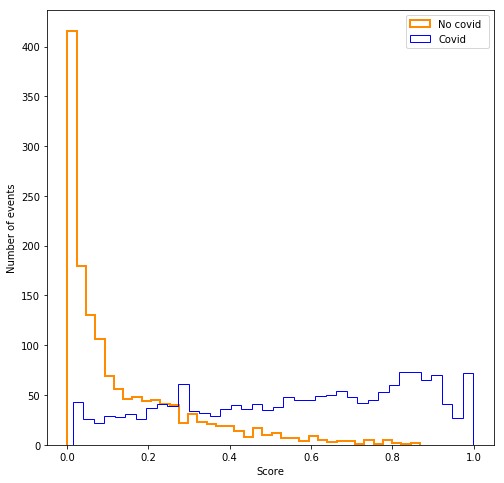

In [69]:
import matplotlib.pyplot as plt
pred = model.predict(X_test)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
plt.style.use('seaborn-deep')
plt.hist(Mean[(Y_test==0)],38,histtype='step',color='darkorange',lw=2,label= "No covid" )
plt.hist(Mean[Y_test==1],38,histtype='step',color='blue',lw=1 ,label="Covid")
plt.ylabel('Number of events')
plt.xlabel('Score')
plt.legend(loc="upper right")
plt.show()
#plt.savefig(filename)

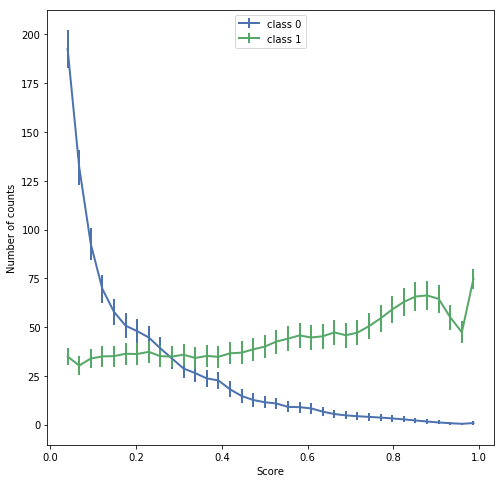

In [66]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
intervalos=intervalos[:-1]
intervalos += intervalos[1]/2
plt.style.use('seaborn-deep')
plt.errorbar(intervalos, dic_cuentas[0] , yerr=dic_dest[0],lw=2, label ="No covid")
plt.errorbar(intervalos, dic_cuentas[1] , yerr=dic_dest[1],lw=2, label ="Covid")
plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.legend(loc="upper center")
#plt.savefig(filename)

In [80]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Mean)
fpr_U, tpr_U, thr = roc_curve(Y_test,Mean+unc)
fpr_L, tpr_L, thr = roc_curve(Y_test,Mean-unc)
roc_auc = auc(fpr,tpr)
roc_auc_U = auc(fpr_U,tpr_U)
roc_auc_L = auc(fpr_L,tpr_L)

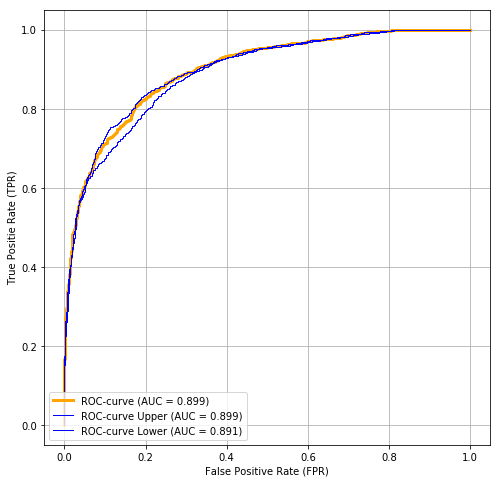

In [81]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
#plt.title("Simulation", weight="bold", x=0.50)
plt.grid(True)
#yticks(np.arange(0.97, 1, step=0.005))
lw = 2
plt.plot(fpr, tpr, color='orange',lw=3, label='ROC-curve (AUC = %0.3f)' % (roc_auc))
plt.plot(fpr_U, tpr_U, color='blue',lw=1, label='ROC-curve Upper (AUC = %0.3f)' % (roc_auc_U))
plt.plot(fpr_L, tpr_L, color='blue',lw=1, label='ROC-curve Lower (AUC = %0.3f)' % (roc_auc_L))



plt.ylabel('True Positie Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

#plt.title("Simulation Preliminary", color = '#e159e1',loc="left", weight="bold", size="large")
plt.legend(loc="lower left")
plt.show()